In [1]:
import numpy as np

import tensorflow as tf
import pandas as pd
import os

import random
from dataloader import Gen_Data_loader, Dis_dataloader
from generator import Generator
from discriminator import Discriminator
from rollout import ROLLOUT

#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 8 # embedding dimension
HIDDEN_DIM = 8 # hidden state dimension of lstm cell
SEQ_LENGTH = 50 # sequence length
START_TOKEN = [0., 0., 0]
SEED = 88
BATCH_SIZE = 64
VOCAB_SIZE = 112  # 111 categories and 1 start_token

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = 16
dis_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
dis_num_filters = [50, 100, 100, 100, 100, 50, 50, 50, 50, 50, 80, 80]
dis_dropout_keep_prob = 0.75
dis_l2_reg_lambda = 0.2
dis_batch_size = 64

real_data_file = 'CDS_Preprocessed_Data.h5.gz'
MODEL_FILE = "results3/model.ckpt"
OUTPUT_DATAFRAME = "./results3/CDS_Preprocessed_Data_results.h5.gz"


def generate_samples(sess, trainable_model, batch_size, generated_num, output_file=None):
    # Generate Samples
    generated_samples = []
    for _ in range(int(generated_num / batch_size)):
        generated_samples.extend(trainable_model.generate(sess))

    data = []
    for sequence in generated_samples:
        data.extend(sequence)
    df = pd.DataFrame(data=data, columns=["PRICE", "ROUNDED_NOTIONAL_AMOUNT", "category"])
    df = df.astype({"category": 'int32'})
    if output_file is not None:
        df.to_hdf(output_file, key="CDS", complib="zlib", complevel=9, mode='w')
    
    return df

In [2]:
random.seed(SEED)
np.random.seed(SEED)

generator = Generator(VOCAB_SIZE, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN)

discriminator = Discriminator(sequence_length=SEQ_LENGTH, num_classes=2, vocab_size=VOCAB_SIZE, embedding_size=dis_embedding_dim,
                            filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)

config = tf.ConfigProto()
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

saver.restore(sess, MODEL_FILE)
print("Model restored.")





Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


INFO:tensorflow:Restoring parameters from results3/model.ckpt
Model restored.


In [3]:
generated_num = 37212 // SEQ_LENGTH

generated_data = generate_samples(sess, generator, BATCH_SIZE, generated_num)

In [4]:
len(generated_data)

35200

In [5]:
real_data = pd.read_hdf(real_data_file)

In [6]:
real_data.head(30)

,PRICE,ROUNDED_NOTIONAL_AMOUNT,CLEARED,ACTION,TAXONOMY,PRICE_FORMING_CONTINUATION_DATA,INDICATION_OF_COLLATERALIZATION
0,0.668500,25.0,C,NEW,CDXIG,Trade,PC
1,0.668500,50.0,C,NEW,CDXIG,Trade,PC
2,0.476875,150.0,C,NEW,CDXIG,Trade,PC
3,0.478750,85.0,C,NEW,CDXIG,Trade,PC
4,0.680000,62.0,C,NEW,CDXIG,Trade,PC
5,0.678125,110.0,C,NEW,CDXIG,Trade,PC
6,0.678000,100.0,C,NEW,CDXIG,Trade,PC
7,0.678000,100.0,C,CANCEL,CDXIG,Trade,PC
8,0.678000,100.0,C,CORRECT,CDXIG,Trade,PC
9,0.678000,25.0,C,NEW,CDXIG,Trade,UC


In [7]:
len(real_data)

37212

In [8]:
generated_data.head()

,PRICE,ROUNDED_NOTIONAL_AMOUNT,category
0,0.052085,0.074147,76
1,0.052031,0.074114,72
2,0.052069,0.074133,24
3,0.052055,0.074061,34
4,0.052086,0.073957,75


In [9]:
import pickle
with open("index_to_category.pkl", "rb") as f:
    index_to_category = pickle.load(f)

len(index_to_category)

112

In [10]:
generated_data["CLEARED"] = ""
generated_data["ACTION"] = ""
generated_data["TAXONOMY"] = ""
generated_data["PRICE_FORMING_CONTINUATION_DATA"] = ""
generated_data["INDICATION_OF_COLLATERALIZATION"] = ""

for i in range(len(generated_data)):
    tmp = index_to_category[generated_data["category"][i]]
    generated_data["CLEARED"][i], \
    generated_data["ACTION"][i], \
    generated_data["TAXONOMY"][i], \
    generated_data["PRICE_FORMING_CONTINUATION_DATA"][i], \
    generated_data["INDICATION_OF_COLLATERALIZATION"][i] = \
    tmp.split(",") if tmp != "<start>" else ("N/A", "N/A", "N/A", "N/A", "N/A")

generated_data.head()

/home/philippe/.virtualenvs/fintech/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PRICE,ROUNDED_NOTIONAL_AMOUNT,category,CLEARED,ACTION,TAXONOMY,PRICE_FORMING_CONTINUATION_DATA,INDICATION_OF_COLLATERALIZATION
0,0.052085,0.074147,76,U,CANCEL,CDXIG,Partialtermination,UC
1,0.052031,0.074114,72,U,CORRECT,CDXHY,Novation,PC
2,0.052069,0.074133,24,C,CANCEL,CDXIG,Amendment,PC
3,0.052055,0.074061,34,U,CANCEL,CDXIG,Trade,PC
4,0.052086,0.073957,75,U,NEW,CDXHY,Trade,UC


In [11]:
generated_data.head(30)

,PRICE,ROUNDED_NOTIONAL_AMOUNT,category,CLEARED,ACTION,TAXONOMY,PRICE_FORMING_CONTINUATION_DATA,INDICATION_OF_COLLATERALIZATION
0,0.052085,0.074147,76,U,CANCEL,CDXIG,Partialtermination,UC
1,0.052031,0.074114,72,U,CORRECT,CDXHY,Novation,PC
2,0.052069,0.074133,24,C,CANCEL,CDXIG,Amendment,PC
3,0.052055,0.074061,34,U,CANCEL,CDXIG,Trade,PC
4,0.052086,0.073957,75,U,NEW,CDXHY,Trade,UC
5,0.052041,0.074142,64,U,CORRECT,CDXHY,Amendment,FC
6,0.052067,0.074030,2,U,NEW,CDXHY,Amendment,PC
7,0.052025,0.074030,28,U,NEW,CDXHY,Novation,UC
8,0.051968,0.074027,63,C,CANCEL,CDXIG,Trade,OC
9,0.051947,0.073951,0,N/A,N/A,N/A,N/A,N/A


In [12]:
generated_data.to_hdf(OUTPUT_DATAFRAME, key="CDS", complib="zlib", complevel=9, mode='w')

In [13]:
sum(generated_data["category"]) / sum(generated_data["category"] == 0)

6229.84076433121

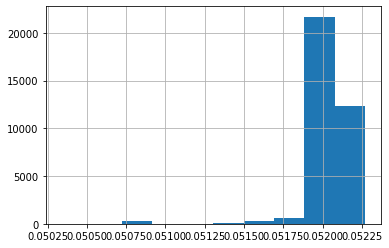

In [14]:
generated_data["PRICE"].hist()

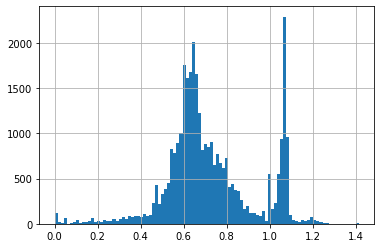

In [15]:
real_data["PRICE"][real_data["PRICE"] < 1.5][real_data["PRICE"] > 0].hist(bins=100)

In [16]:
len(real_data["PRICE"][real_data["PRICE"] < 1.5][real_data["PRICE"] > 0]) / len(real_data["PRICE"])

0.8841771471568312

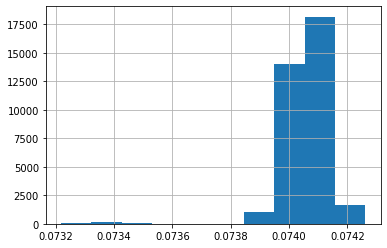

In [17]:
generated_data["ROUNDED_NOTIONAL_AMOUNT"].hist()

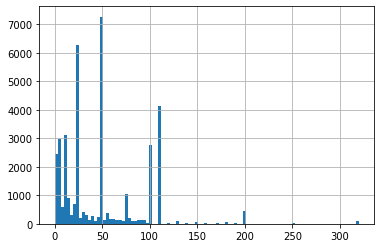

In [18]:
real_data["ROUNDED_NOTIONAL_AMOUNT"].hist(bins=100)

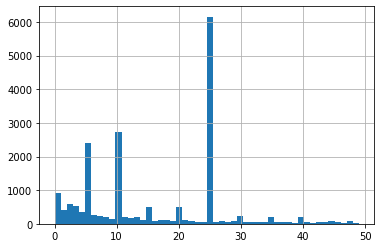

In [19]:
real_data[real_data["ROUNDED_NOTIONAL_AMOUNT"] < 50]["ROUNDED_NOTIONAL_AMOUNT"].hist(bins=50)

In [20]:
import matplotlib.pyplot as plt

def plot_pie(column, data, title):
    data[data[column] != "N/A"][["PRICE", column]].groupby(column).count().plot(kind="pie", subplots=True)
    plt.axis('equal')
    plt.ylabel(column)
    plt.title(title)
    plt.show()

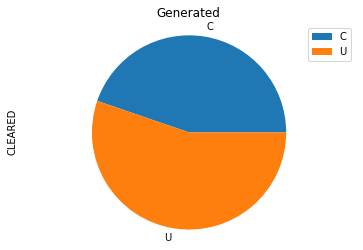

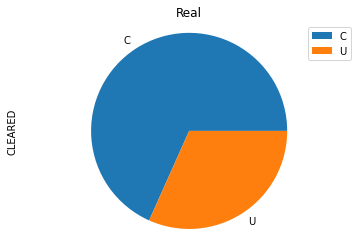

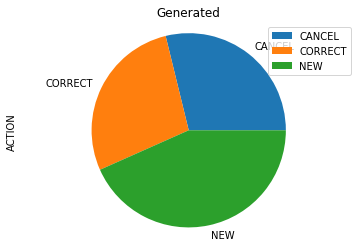

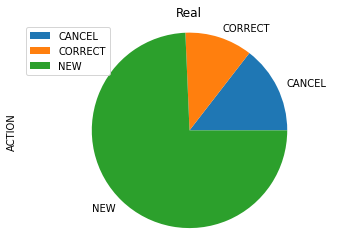

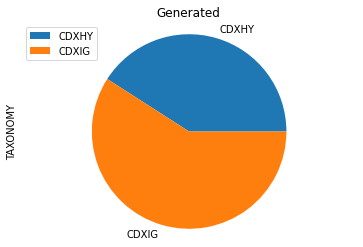

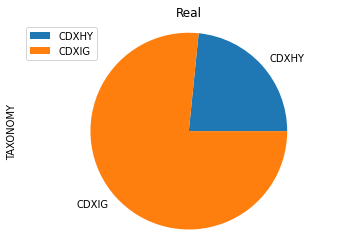

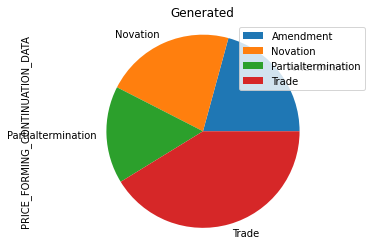

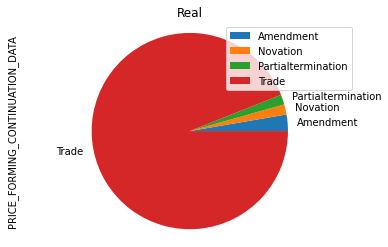

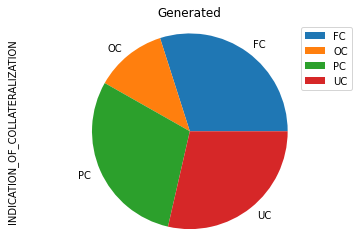

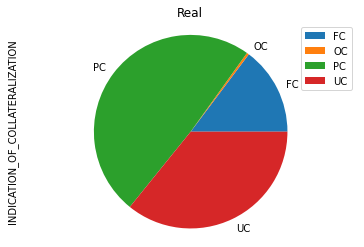

In [21]:
for column in generated_data.columns[3:]:
    plot_pie(column, generated_data, "Generated")
    plot_pie(column, real_data, "Real")